In [1]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np

show_animation = True

Once we have config space with obstacles, we define a start and goal point defined.
Sample a random point from start, and know distance, next iter  get another point. Choose node closest to the point and move a specific distance in that direction. Ignore iteration sample if the path crosses through an obstacle, 
next iter always choose the nearest node. Keep going till we reach goal.

Every iteration, need to check if waypoint is feasible

In [ ]:
class RRT:
    """
    Class for RRT planning
    """

    class Node:
        # Node Class

        def __init__(self, x, y):
            self.x = x
            self.y = y
            self.path_x = []
            self.path_y = []
            self.parent = None

    class AreaBounds:

        def __init__(self, area):
            self.xmin = float(area[0])
            self.xmax = float(area[1])
            self.ymin = float(area[2])
            self.ymax = float(area[3])


    def __init__(self,
                 start,
                 goal,
                 obstacle_list,
                 rand_area,
                 expand_dis=3.0,
                 path_resolution=0.5,
                 goal_sample_rate=5,
                 max_iter=500,
                 play_area=None,
                 robot_radius=0.0,
                 ):
        """
        Setting Parameter
        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Random Sampling Area [min,max]
        lenght of each expansion branch
        play_area:stay inside this area [xmin,xmax,ymin,ymax]
        robot_radius: robot body modeled as circle with given radius
        """
        self.start = self.Node(start[0], start[1])
        self.end = self.Node(goal[0], goal[1])

        self.min_rand = rand_area[0]
        self.max_rand = rand_area[1]

        self.obstacle_list = obstacle_list
        self.expand_dis = expand_dis

        self.goal_sample_rate = goal_sample_rate
        self.path_resolution = path_resolution
        self.robot_radius = robot_radius
        self.max_iter = 500
        if play_area is not None:
            self.play_area = self.AreaBounds(play_area)
        else:
            self.play_area = None
       
    def planning(self, animation=True):
        """
        rrt path planning
        animation: flag for animation on or off
        """

        self.node_list = [self.start]
        for i in range(self.max_iter):
            rnd_node = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd_node)
            nearest_node = self.node_list[nearest_ind]

            new_node = self.steer(nearest_node, rnd_node, self.expand_dis)

            if self.check_if_outside_play_area(new_node, self.play_area) and \
               self.check_collision(
                   new_node, self.obstacle_list, self.robot_radius):
                self.node_list.append(new_node)

            if animation and i % 5 == 0:
                self.draw_graph(rnd_node)

            if self.calc_dist_to_goal(self.node_list[-1].x,
                                      self.node_list[-1].y) <= self.expand_dis:
                final_node = self.steer(self.node_list[-1], self.end,
                                        self.expand_dis)
                if self.check_collision(
                        final_node, self.obstacle_list, self.robot_radius):
                    return self.generate_final_course(len(self.node_list) - 1)

            if animation and i % 5:
                self.draw_graph(rnd_node)

        return None  # cannot find path

    def steer(self, from_node, to_node, extend_length=float("inf")):

        new_node = self.Node(from_node.x, from_node.y)
        d, theta = self.calc_distance_and_angle(new_node, to_node)

        new_node.path_x = [new_node.x]
        new_node.path_y = [new_node.y]

        if extend_length > d:
            extend_length = d

        n_expand = math.floor(extend_length / self.path_resolution)

        for _ in range(n_expand):
            new_node.x += self.path_resolution * math.cos(theta)
            new_node.y += self.path_resolution * math.sin(theta)
            new_node.path_x.append(new_node.x)
            new_node.path_y.append(new_node.y)

        d, _ = self.calc_distance_and_angle(new_node, to_node)
        if d <= self.path_resolution:
            new_node.path_x.append(to_node.x)
            new_node.path_y.append(to_node.y)
            new_node.x = to_node.x
            new_node.y = to_node.y

        new_node.parent = from_node

        return new_node

    def generate_final_course(self, goal_ind):
        path = [[self.end.x, self.end.y]]
        node = self.node_list[goal_ind]
        while node.parent is not None:
            path.append([node.x, node.y])
            node = node.parent
        path.append([node.x, node.y])

        return path

    def calc_dist_to_goal(self, x, y):
        dx = x - self.end.x
        dy = y - self.end.y
        return math.hypot(dx, dy)

    def get_random_node(self):
        if random.randint(0, 100) > self.goal_sample_rate:
            rnd = self.Node(
                random.uniform(self.min_rand, self.max_rand),
                random.uniform(self.min_rand, self.max_rand))
        else:  # goal point sampling
            rnd = self.Node(self.end.x, self.end.y)
        return rnd

    def draw_graph(self, rnd=None):
        plt.clf()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect(
            'key_release_event',
            lambda event: [exit(0) if event.key == 'escape' else None])
        if rnd is not None:
            plt.plot(rnd.x, rnd.y, "^k")
            if self.robot_radius > 0.0:
                self.plot_circle(rnd.x, rnd.y, self.robot_radius, '-r')
        for node in self.node_list:
            if node.parent:
                plt.plot(node.path_x, node.path_y, "-g")

        for (ox, oy, size) in self.obstacle_list:
            self.plot_circle(ox, oy, size)

        if self.play_area is not None:
            plt.plot([self.play_area.xmin, self.play_area.xmax,
                      self.play_area.xmax, self.play_area.xmin,
                      self.play_area.xmin],
                     [self.play_area.ymin, self.play_area.ymin,
                      self.play_area.ymax, self.play_area.ymax,
                      self.play_area.ymin],
                     "-k")

        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.axis("equal")
        plt.axis([-2, 15, -2, 15])
        plt.grid(True)
        plt.pause(0.01)

    @staticmethod
    def plot_circle(x, y, size, color="-b"):  # pragma: no cover
        deg = list(range(0, 360, 5))
        deg.append(0)
        xl = [x + size * math.cos(np.deg2rad(d)) for d in deg]
        yl = [y + size * math.sin(np.deg2rad(d)) for d in deg]
        plt.plot(xl, yl, color)

    @staticmethod
    def get_nearest_node_index(node_list, rnd_node):
        dlist = [(node.x - rnd_node.x)**2 + (node.y - rnd_node.y)**2
                 for node in node_list]
        minind = dlist.index(min(dlist))

        return minind

    @staticmethod
    def check_if_outside_play_area(node, play_area):

        if play_area is None:
            return True  # no play_area was defined, every pos should be ok

        if node.x < play_area.xmin or node.x > play_area.xmax or \
           node.y < play_area.ymin or node.y > play_area.ymax:
            return False  # outside - bad
        else:
            return True  # inside - ok

    @staticmethod
    def check_collision(node, obstacleList, robot_radius):

        if node is None:
            return False

        for (ox, oy, size) in obstacleList:
            dx_list = [ox - x for x in node.path_x]
            dy_list = [oy - y for y in node.path_y]
            d_list = [dx * dx + dy * dy for (dx, dy) in zip(dx_list, dy_list)]

            if min(d_list) <= (size+robot_radius)**2:
                return False  # collision

        return True  # safe

    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = math.hypot(dx, dy)
        theta = math.atan2(dy, dx)
        return d, theta




start 


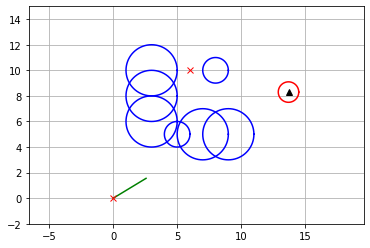

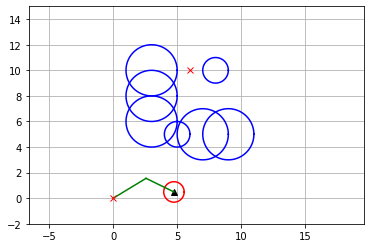

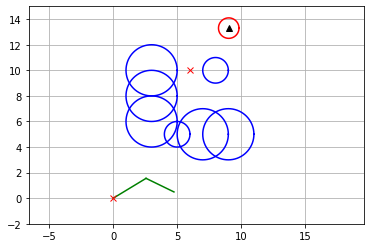

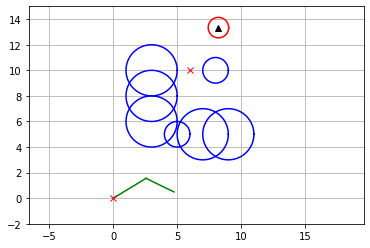

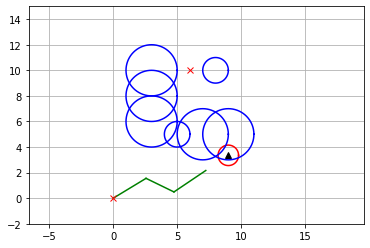

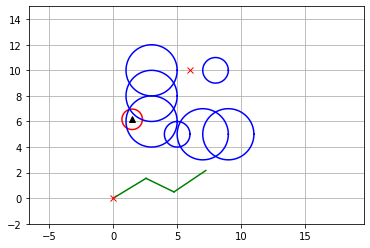

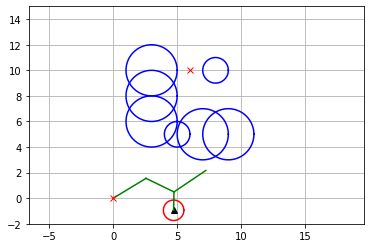

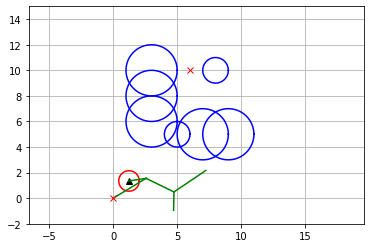

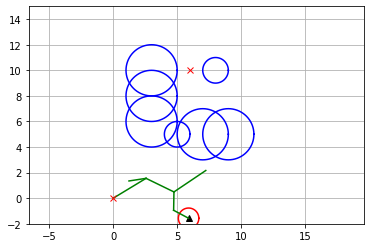

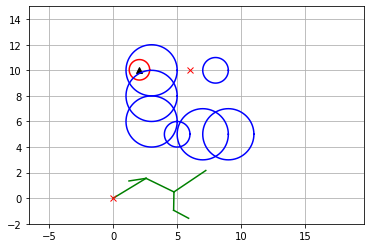

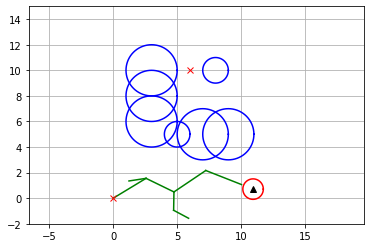

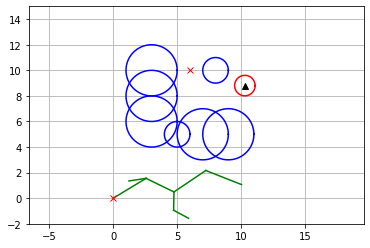

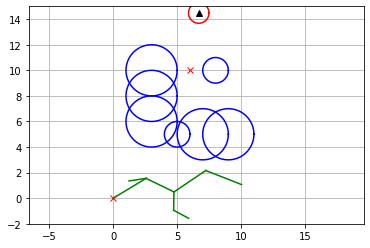

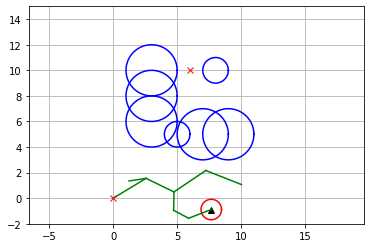

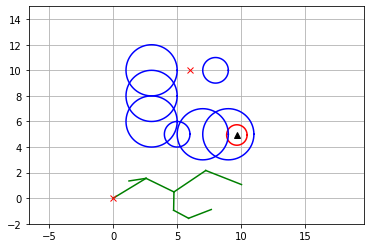

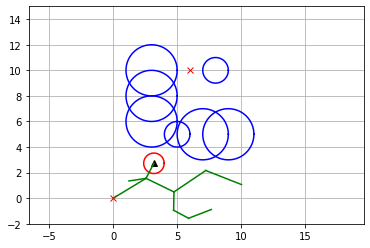

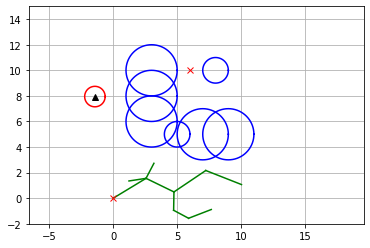

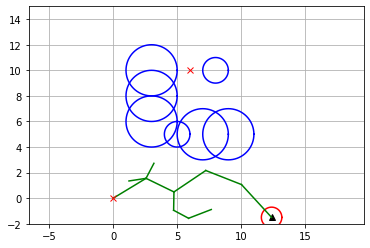

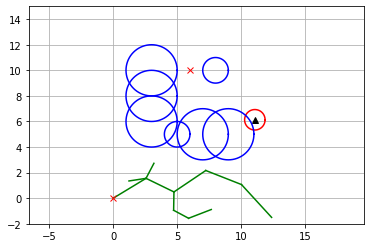

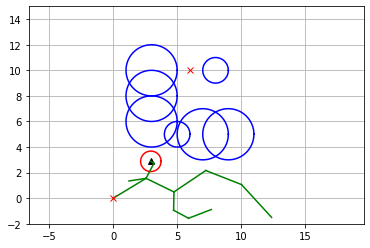

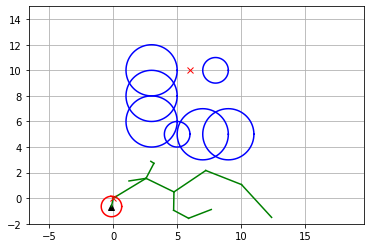

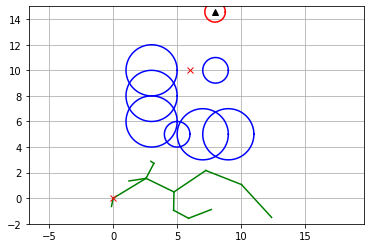

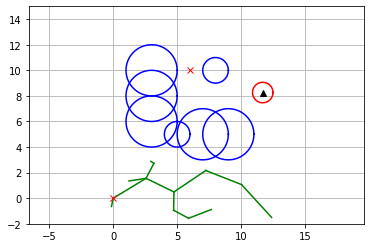

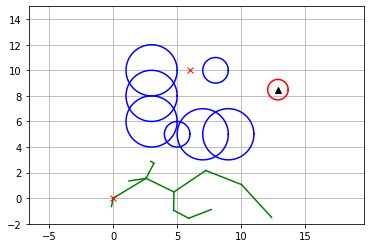

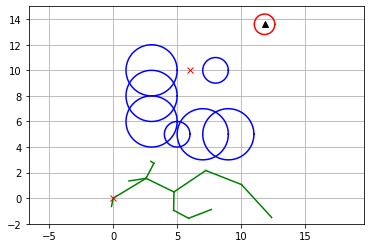

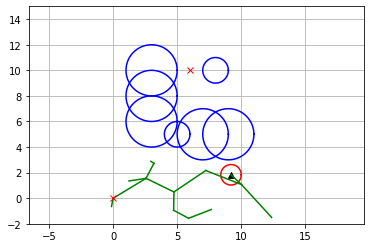

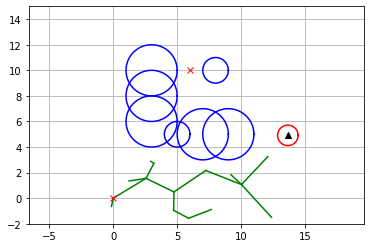

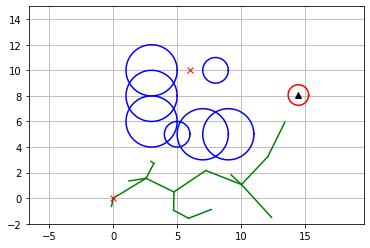

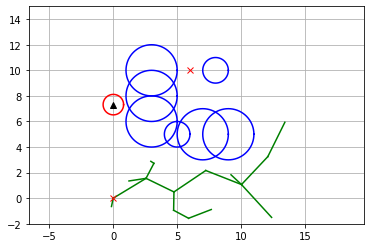

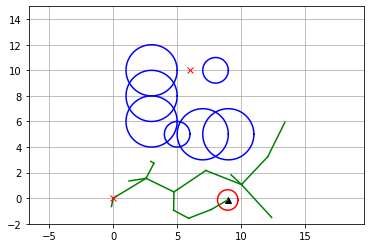

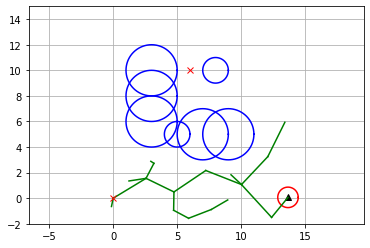

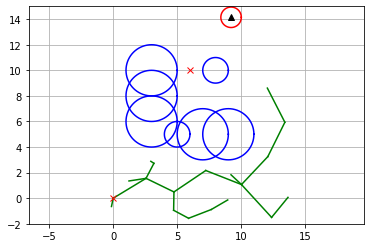

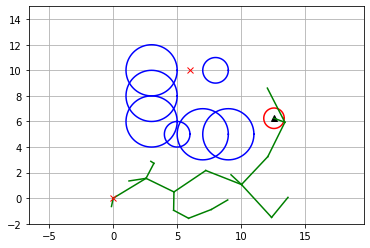

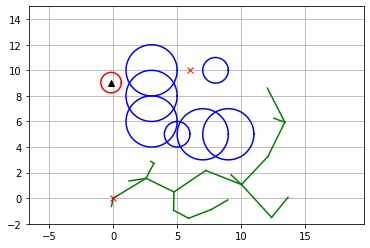

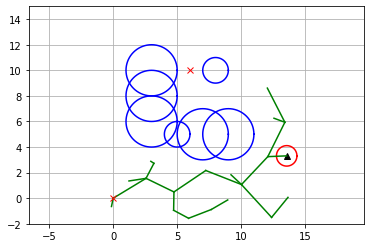

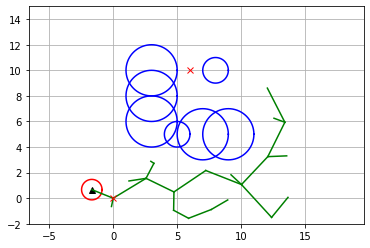

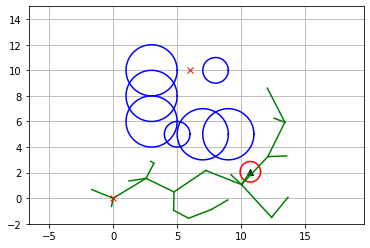

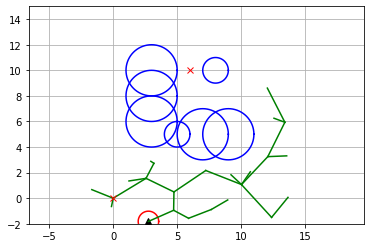

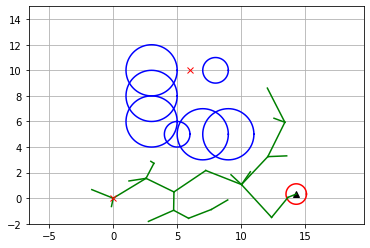

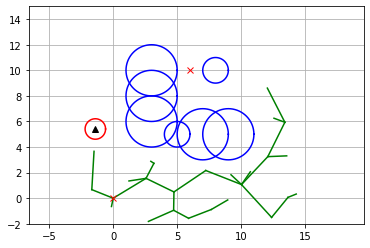

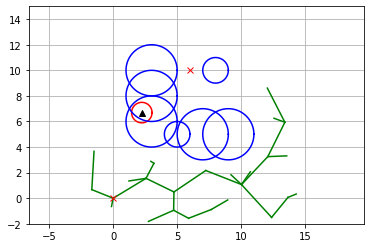

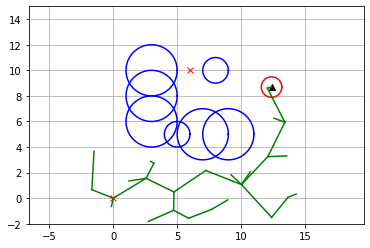

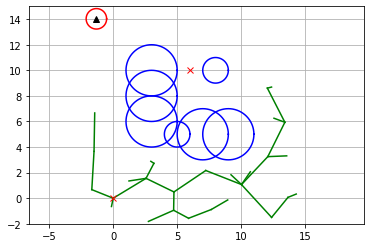

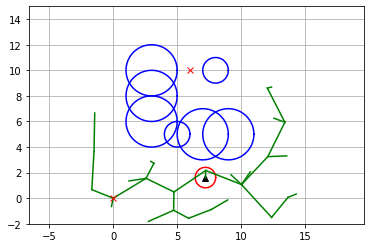

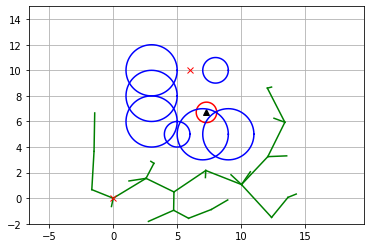

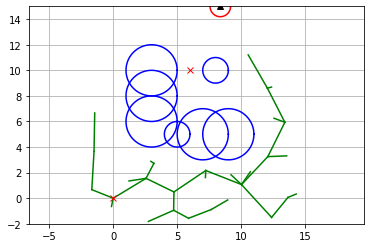

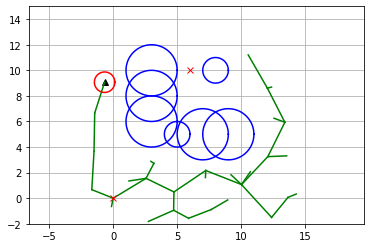

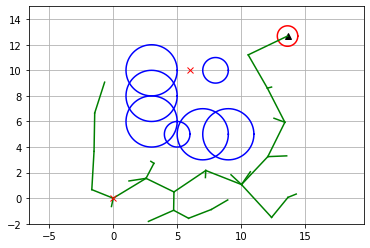

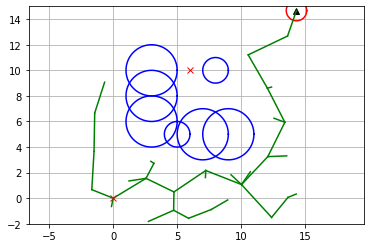

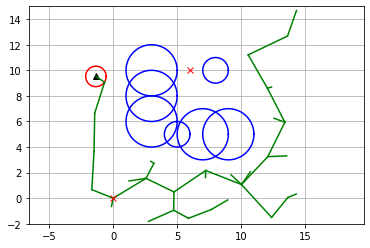

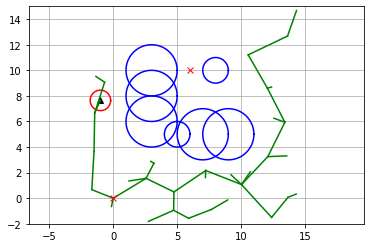

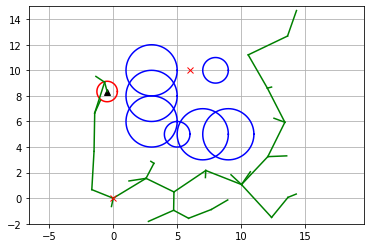

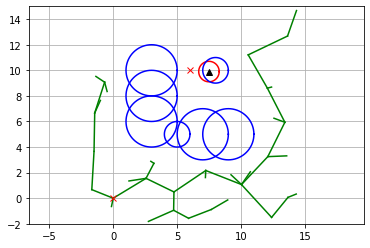

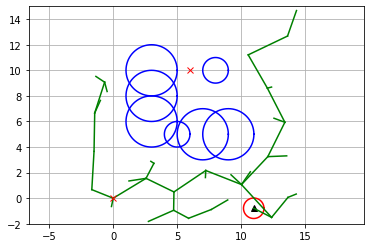

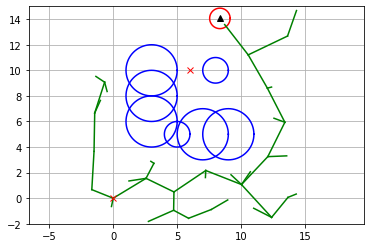

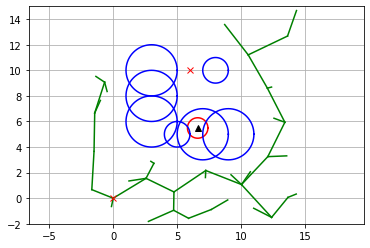

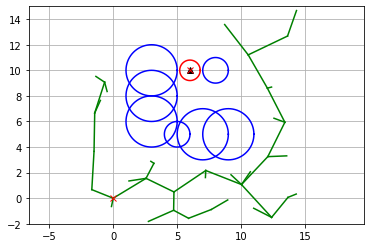

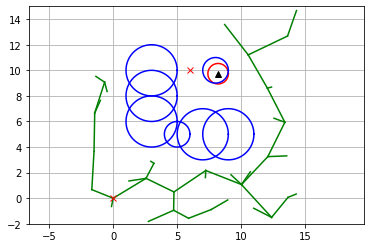

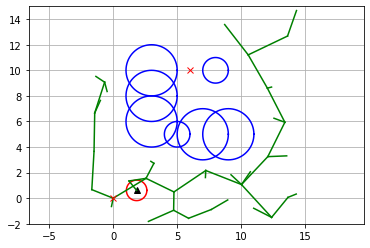

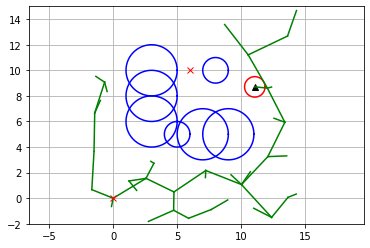

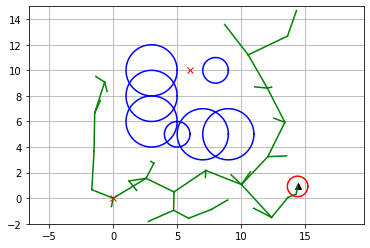

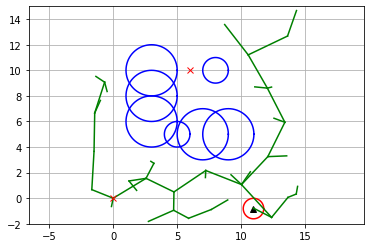

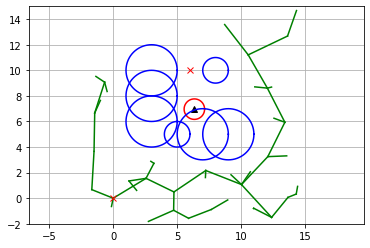

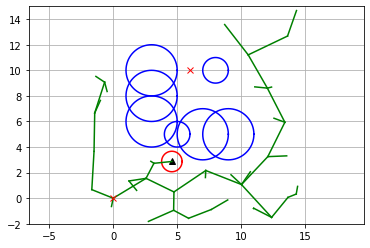

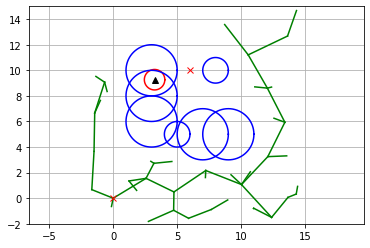

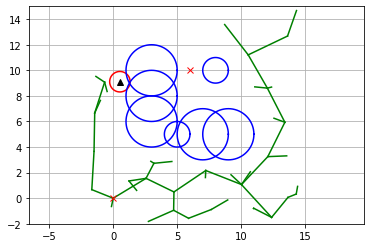

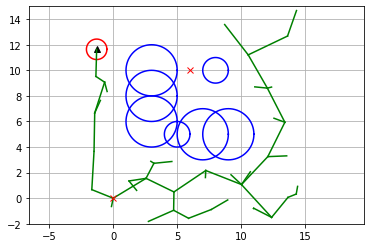

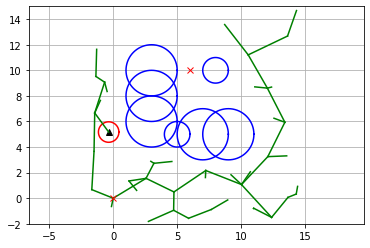

found path!!


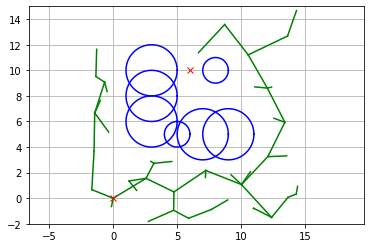

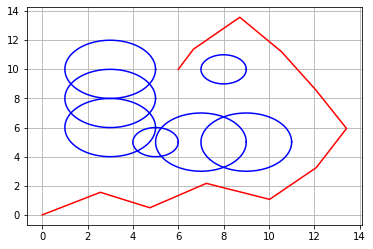

In [ ]:
    gx = 6.0
    gy = 10.0
    print("start " )

    # ====Search Path with RRT====
    obstacleList = [(5, 5, 1), (3, 6, 2), (3, 8, 2), (3, 10, 2), (7, 5, 2),
                    (9, 5, 2), (8, 10, 1)]  # [x, y, radius]
    # Set Initial parameters
    rrt = RRT(
        start=[0, 0],
        goal=[gx, gy],
        rand_area=[-2, 15],
        obstacle_list=obstacleList,
        # play_area=[0, 10, 0, 14]
        robot_radius=0.8
        )
    path = rrt.planning(animation=show_animation)

    if path is None:
        print("Cannot find path")
    else:
        print("found path!!")

        # Draw final path
        if show_animation:
            rrt.draw_graph()
            plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r')
            for (ox, oy, size) in obstacleList:
              rrt.plot_circle(ox, oy, size)

            plt.grid(True)
            plt.pause(0.01)  # Need for Mac
            plt.show()